In [1]:
import networkx as nx

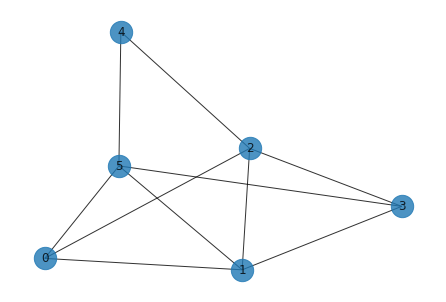

In [48]:
G = nx.Graph()
G.add_edges_from([(1, 2), (2, 3), (3, 0), (0, 1)])
# G = nx.gnp_random_graph(6, 0.8)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [49]:
import pennylane as qml
from pennylane.templates import ApproxTimeEvolution
from pennylane import numpy as np

In [50]:
def x(wire):
    return qml.Hamiltonian([0.5, -0.5], [qml.Identity(wire), qml.PauliZ(wire)])

In [51]:
def create_cost_hamiltonian(graph: nx.Graph, gamma, time=1):
    hamiltonian = qml.Identity(0) #  remove
    for edge in graph.edges:
        hamiltonian -= gamma * x(edge[0])
        hamiltonian -= gamma * x(edge[1])
        hamiltonian += gamma * 2 *(x(edge[0]) @ x(edge[1]))
    ApproxTimeEvolution(hamiltonian, time, 1)

In [52]:
def create_mixing_hamitonian(wires, beta, time=1):
    hamiltonian = qml.Identity(0)
    for i in range(wires):
        hamiltonian += qml.Hamiltonian([beta], [qml.PauliX(i)])
    ApproxTimeEvolution(hamiltonian, time, 1)

In [53]:
def hadamard_layer(wires):
    for i in range(wires):
        qml.Hadamard(i)

In [54]:
n_wires = 4
dev = qml.device("default.qubit", wires=n_wires, shots=1)

In [55]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z, requires_grad=False)
pauli_z_4 = np.kron(pauli_z_2, pauli_z_2, requires_grad=False)

@qml.qnode(dev)
def circuit(gammas, betas, graph, n_layers=1):
    hadamard_layer(graph.number_of_nodes())
    for i in range(n_layers):
        create_cost_hamiltonian(graph, gammas[i])
        create_mixing_hamitonian(graph.number_of_nodes(), betas[i])

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(graph.number_of_nodes())]
    # return qml.expval(qml.Hermitian(pauli_z_2, wires=graph.number_of_nodes()))

/tmp/ipykernel_7162/3053237160.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


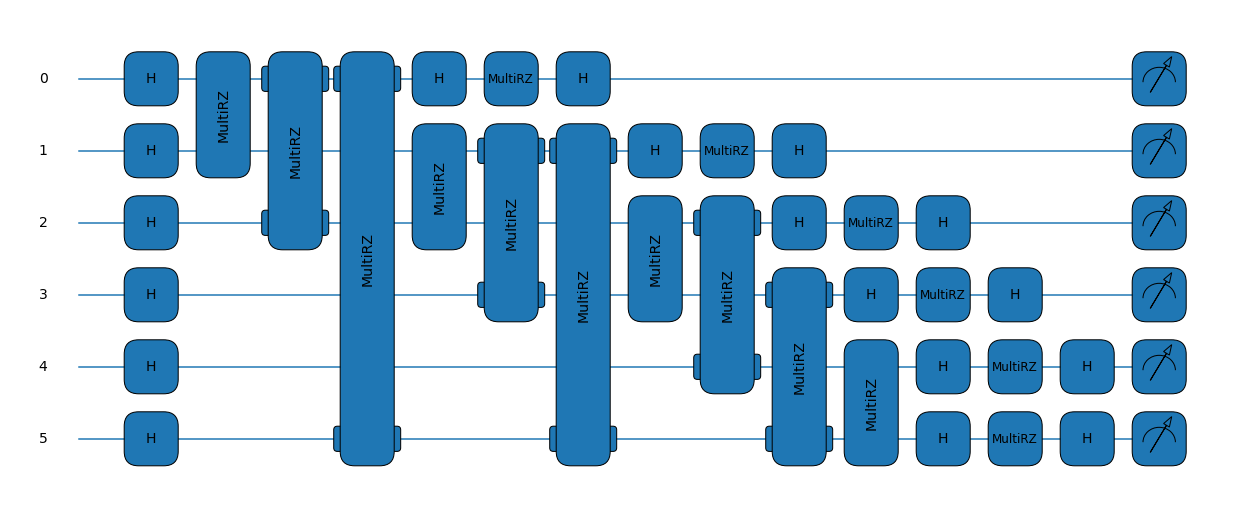

In [56]:
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")([0], [0], G)
fig.show()

In [57]:
result = circuit([0, 0], [0, 0], G, n_layers=2)
int(result[0]*result[1])

WireError: Wire with label 4 not found in <Wires = [0, 1, 2, 3]>.

In [58]:
def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

In [43]:
%load_ext autoreload
%autoreload 2
from CEM_optimizer_pennylane import CEMOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
def qaoa_maxcut(n_layers=1):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = ([0]*n_layers*2)

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[:len(params)//2]
        betas = params[len(params)//2:]
        result = circuit(gammas, betas, G, n_layers)
        sum = 0

        for edge in G.edges():
            sum -= (1 - int(result[edge[0]]*result[edge[1]]))/2
        return sum

    # initialize optimizer: Adagrad works well empirically
    opt = CEMOptimizer(init_params)

    # optimize parameters in objective
    params = init_params
    steps = 1
    for i in range(steps):
        params = opt.step(objective)
        if (i + 1) % 5 == 0:
            print(params)
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    # sample measured bitstrings 100 times
    # bit_strings = []
    # n_samples = 100
    # for i in range(0, n_samples):
    #     bit_strings.append(bitstring_to_int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    # counts = np.bincount(np.array(bit_strings))
    # most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params))
    # print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return -objective(params)


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
# bitstrings1 = qaoa_maxcut(n_layers=1)[1]
bitstrings2 = qaoa_maxcut(n_layers=2)


p=2
Episode 5	Average Score: -2.00
[-0.57596516  0.37033964 -0.35081149  0.78175225] with reward: -4.0
Episode 10	Average Score: -2.40
[-0.57596516  0.37033964 -0.35081149  0.78175225] with reward: -4.0
Optimized (gamma, beta) vectors:
[-0.57596516  0.37033964 -0.35081149  0.78175225]
